## 데이터 디렉토리 만들기

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:

import os
import shutil

# Colab에 저장할 디렉토리 생성
os.makedirs('/content/rsna_data', exist_ok=True)


In [27]:
# 파일 업로드
from google.colab import files

uploaded = files.upload()

# 업로드된 파일을 /content/rsna_data로 이동
for filename in uploaded.keys():
    shutil.move(filename, f'/content/rsna_data/{filename}')
    print(f"Moved {filename} to /content/rsna_data")  ##drrive에놓고 복사하는거 수정필요.

Saving train_labels_all.csv to train_labels_all.csv
Moved train_labels_all.csv to /content/rsna_data


In [4]:
!pip install pydicom
import pydicom
import copy
import os.path as osp
import cv2
import numpy as np

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 23.6 MB/s eta 0:00:00


In [28]:
# 집파일 복사해서 가져옴
import shutil
shutil.copy("/content/drive/MyDrive/Colab Notebooks/컴퓨터비전/stage_2_train_images.zip", "/content/rsna_data")


'/content/rsna_data/stage_2_train_images.zip'

In [30]:
#zip파일풀어서 "/content/rsna_data/total_images"에 놓음 dcm파일임
import zipfile
import os

os.makedirs("/content/rsna_data/total_images", exist_ok=True)
with zipfile.ZipFile("/content/rsna_data/stage_2_train_images.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/rsna_data/total_images")


In [ ]:
#dcm -> jpg
import os
import random
import pydicom
from PIL import Image

# 경로 설정
total_images_dir = "/content/rsna_data/total_images"
output_jpg_dir = "/content/rsna_data/total_images_jpg"

# 디렉토리 생성 (변환된 JPG 이미지 저장)
os.makedirs(output_jpg_dir, exist_ok=True)

# DICOM -> JPG 변환 함수
def convert_dicom_to_jpg(dicom_path, jpg_path):
    try:
        # DICOM 파일 읽기
        dicom_data = pydicom.dcmread(dicom_path)
        pixel_array = dicom_data.pixel_array
        # 이미지 변환 및 저장
        image = Image.fromarray(pixel_array)
        image = image.convert("L")  # 흑백 이미지로 변환
        image.save(jpg_path)
    except Exception as e:
        print(f"Error converting {dicom_path} to JPG: {e}")

# DICOM 파일 목록 가져오기
all_files = [f for f in os.listdir(total_images_dir) if f.endswith(".dcm")]

# 파일 변환 및 저장
for dicom_file in all_files:
    dicom_path = os.path.join(total_images_dir, dicom_file)
    jpg_file = os.path.splitext(dicom_file)[0] + ".jpg"  # 파일 확장자 변경
    jpg_path = os.path.join(output_jpg_dir, jpg_file)

    # DICOM -> JPG 변환
    convert_dicom_to_jpg(dicom_path, jpg_path)
    print(f"Converted {dicom_path} -> {jpg_path}")

print("모든 DICOM 파일이 JPG로 변환되었습니다.")


In [32]:
## Train,Val,Test만들기
import os
import shutil
import pandas as pd
from sklearn.model_selection import train_test_split

# 1단계: CSV 파일 로드
csv_file_path = '/content/rsna_data/train_labels_all.csv'  # 실제 파일 경로
df = pd.read_csv(csv_file_path)

# 2단계: 필요한 폴더 구조 생성
base_dir = '/content/rsna_data/'
output_dir = os.path.join(base_dir, 'split_data')  # 최종 분할된 데이터 폴더
os.makedirs(output_dir, exist_ok=True)

# train, val, test 폴더 생성
for subset in ['train', 'val', 'test']:
    os.makedirs(os.path.join(output_dir, subset, 'Target0'), exist_ok=True)
    os.makedirs(os.path.join(output_dir, subset, 'Target1'), exist_ok=True)

# 3단계: Target0, Target1에 대해 데이터 분할
df_target_0 = df[df['Target'] == 0]
df_target_1 = df[df['Target'] == 1]

# 각 Target에 대해 60% train, 20% val, 20% test로 분할
train_0, temp_0 = train_test_split(df_target_0, test_size=0.4, random_state=42)
val_0, test_0 = train_test_split(temp_0, test_size=0.5, random_state=42)

train_1, temp_1 = train_test_split(df_target_1, test_size=0.4, random_state=42)
val_1, test_1 = train_test_split(temp_1, test_size=0.5, random_state=42)

# 4단계: 이미지를 해당 폴더로 이동
def move_images(df, subset, target):
    for _, row in df.iterrows():
        patient_id = row['patientId']
        image_file_name = f"{patient_id}.jpg"  # 이미지 파일 확장자 .jpg로 가정

        # 이미지의 원본 경로와 목적지 경로 생성
        src_path = os.path.join(base_dir, 'total_images_jpg', image_file_name)
        dest_path = os.path.join(output_dir, subset, f'Target{target}', image_file_name)

        # 이미지가 존재하면 이동, 존재하지 않으면 경고
        if os.path.exists(src_path):
            shutil.move(src_path, dest_path)
        else:
            print(f"경고: {image_file_name}이(가) {src_path}에 존재하지 않습니다.")

# 5단계: train, val, test 세트에 대해 이미지 이동
move_images(train_0, 'train', 0)
move_images(val_0, 'val', 0)
move_images(test_0, 'test', 0)

move_images(train_1, 'train', 1)
move_images(val_1, 'val', 1)
move_images(test_1, 'test', 1)

print("이미지가 train, val, test 하위의 Target0, Target1 폴더에 성공적으로 분배되었습니다.")


경고: f77b0afe-0085-4ee0-afad-a1e9fda8fe65.jpg이(가) /content/rsna_data/total_images_jpg/f77b0afe-0085-4ee0-afad-a1e9fda8fe65.jpg에 존재하지 않습니다.
경고: 72667b71-9dee-478c-b49d-cade9780abd7.jpg이(가) /content/rsna_data/total_images_jpg/72667b71-9dee-478c-b49d-cade9780abd7.jpg에 존재하지 않습니다.
경고: 8b216d4c-23b0-427e-aa94-d516d4ae9698.jpg이(가) /content/rsna_data/total_images_jpg/8b216d4c-23b0-427e-aa94-d516d4ae9698.jpg에 존재하지 않습니다.
경고: 261341d3-1df2-4cf4-b9a8-b1e02a124900.jpg이(가) /content/rsna_data/total_images_jpg/261341d3-1df2-4cf4-b9a8-b1e02a124900.jpg에 존재하지 않습니다.
경고: bd5c5bfb-67de-4696-b4a9-c50ba34f0fbc.jpg이(가) /content/rsna_data/total_images_jpg/bd5c5bfb-67de-4696-b4a9-c50ba34f0fbc.jpg에 존재하지 않습니다.
경고: 88363702-59f4-4dc3-b3cc-316b9216fdc1.jpg이(가) /content/rsna_data/total_images_jpg/88363702-59f4-4dc3-b3cc-316b9216fdc1.jpg에 존재하지 않습니다.
경고: 2fba3da2-e622-477e-a8fe-8fcc06550b25.jpg이(가) /content/rsna_data/total_images_jpg/2fba3da2-e622-477e-a8fe-8fcc06550b25.jpg에 존재하지 않습니다.
경고: 1b6ac013-a672-4eda-9e69-75b062

## 이미지 시각화

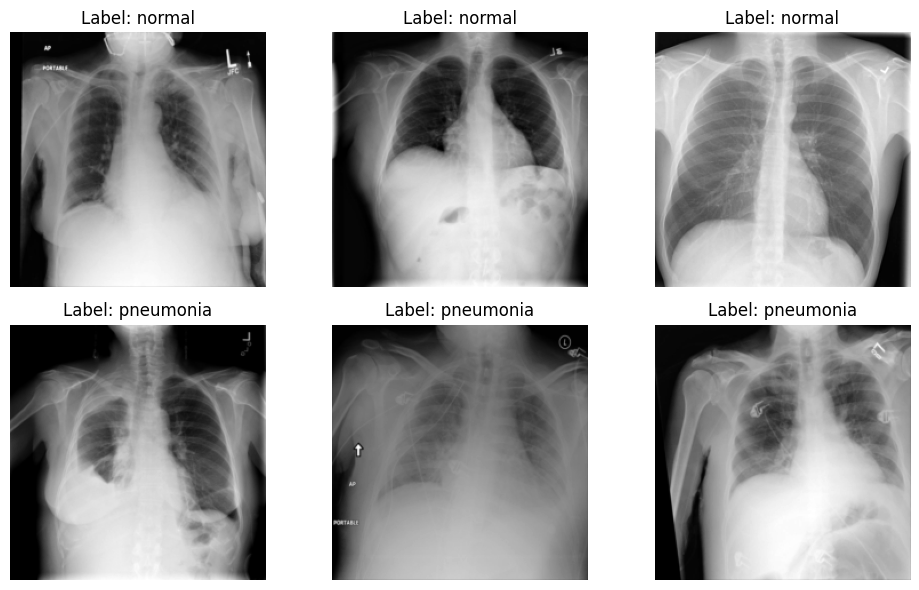

In [62]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
import numpy as np

# 경로 설정
target0_dir = '/content/rsna_data/Target0/train'
target1_dir = '/content/rsna_data/Target1/train'

# 이미지 전처리 (그레이스케일로 로드 후 크기 조정 및 텐서화)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # 이미지 크기 조정
    transforms.Grayscale(num_output_channels=1),  # 그레이스케일로 변환
    transforms.ToTensor(),          # 텐서로 변환
])

# 이미지를 로드하는 함수
def load_random_images_from_folder(folder, num_images=3):
    images = []
    filenames = [f for f in os.listdir(folder) if f.endswith('.jpg')]  # .jpg 파일만 필터링
    random.shuffle(filenames)  # 파일 목록을 랜덤으로 섞기
    selected_files = filenames[:num_images]  # 랜덤으로 선택한 3개의 이미지 파일

    for filename in selected_files:
        img_path = os.path.join(folder, filename)
        img = Image.open(img_path).convert('L')  # 'L' 모드로 그레이스케일 변환
        img = transform(img)  # 이미지 전처리
        images.append(img)

    return images

# 두 폴더에서 각각 3개의 이미지를 랜덤으로 로드
target0_images = load_random_images_from_folder(target0_dir, num_images=3)
target1_images = load_random_images_from_folder(target1_dir, num_images=3)

# 시각화 함수
def visualize_images(images1, images2, class_names=["normal", "pneumonia"]):
    fig, axes = plt.subplots(2, 3, figsize=(10, 6))  # 2x3 형태로 이미지 그리기
    axes = axes.flatten()

    # target0 이미지 (정상)
    for i in range(3):
        img = images1[i].cpu().numpy().squeeze()  # [C, H, W] -> [H, W] (그레이스케일)
        img = np.clip(img, 0, 1)  # 이미지 픽셀 값이 0~1로 조정될 수 있도록
        axes[i].imshow(img, cmap='gray')  # 그레이스케일로 이미지 표시
        axes[i].set_title(f"Label: {class_names[0]}")
        axes[i].axis('off')

    # target1 이미지 (폐렴)
    for i in range(3, 6):
        img = images2[i-3].cpu().numpy().squeeze()  # [C, H, W] -> [H, W] (그레이스케일)
        img = np.clip(img, 0, 1)
        axes[i].imshow(img, cmap='gray')
        axes[i].set_title(f"Label: {class_names[1]}")
        axes[i].axis('off')

    # 여유 공간을 확보하고, 그리드 레이아웃을 맞추기 위해 plt.tight_layout()을 사용합니다.
    plt.tight_layout()
    plt.show()

# 시각화
visualize_images(target0_images, target1_images)


## 커스텀 데이터셋 만들기

In [42]:
#dataloader에 올리기
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# 데이터 경로 설정
base_dir = '/content/rsna_data/split_data'

# 데이터 변환 설정
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # 이미지를 224x224로 크기 조정
    transforms.ToTensor(),         # 이미지를 Tensor로 변환
    transforms.Normalize([0.5], [0.5])  # 평균 0.5, 표준편차 0.5로 정규화
])

# 데이터셋 로드
train_dataset = datasets.ImageFolder(os.path.join(base_dir, 'train'), transform=transform)
val_dataset = datasets.ImageFolder(os.path.join(base_dir, 'val'), transform=transform)
test_dataset = datasets.ImageFolder(os.path.join(base_dir, 'test'), transform=transform)

# DataLoader 생성
batch_size = 128

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# 클래스 확인
print(f"클래스: {train_dataset.classes}")
print(f"클래스 인덱스 매핑: {train_dataset.class_to_idx}")
print(f"학습 데이터 크기: {len(train_dataset)}")
print(f"검증 데이터 크기: {len(val_dataset)}")
print(f"테스트 데이터 크기: {len(test_dataset)}")


클래스: ['Target0', 'Target1']
클래스 인덱스 매핑: {'Target0': 0, 'Target1': 1}
학습 데이터 크기: 16831
검증 데이터 크기: 5067
테스트 데이터 크기: 4786


## 첫번째 모델

In [43]:
import torch
import torch.nn as nn

class MyCNN(nn.Module):
    def __init__(self):
        super(MyCNN, self).__init__()

        # 첫 번째 레이어: Convolution + ReLU + MaxPooling
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),  # 입력 채널: 1, 출력 채널: 32 #rgb3인듯
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 2x2 맥스 풀링 (224 -> 112)
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1), # 입력 채널: 32, 출력 채널: 64
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)   # 2x2 맥스 풀링 (112 -> 56)
        )

        # 두 번째 레이어: Fully Connected (Dense) Layer
        self.layer2 = nn.Sequential(
            nn.Flatten(),                           # 평탄화
            nn.Linear(64 * 56 * 56, 128),           # 수정된 입력 크기
            nn.ReLU(),
            nn.Linear(128, 2)                      # 출력 크기: 2 (클래스 2개)
        )

    def forward(self, x):
        x = self.layer1(x)  # 첫 번째 레이어 통과
        x = self.layer2(x)  # 두 번째 레이어 통과
        return x

# 모델 인스턴스 생성
model = MyCNN()

# 모델 구조 출력
print(model)


MyCNN(
  (layer1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=200704, out_features=128, bias=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=2, bias=True)
  )
)


## 첫번째 모델훈련

In [45]:
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# 하드웨어 설정 (GPU 사용 가능 시 GPU로 설정)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# 모델 생성 및 이동
model = MyCNN().to(device)

# 손실 함수와 옵티마이저 정의
criterion = nn.CrossEntropyLoss()  # 다중 클래스 분류 문제에 적합한 손실 함수
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam 옵티마이저

# 훈련 함수
def train(model, train_loader, optimizer, criterion, device):
    model.train()  # 모델을 훈련 모드로 설정
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)  # 데이터를 GPU로 이동

        # 옵티마이저 초기화
        optimizer.zero_grad()

        # 순전파
        outputs = model(images)
        loss = criterion(outputs, labels)

        # 역전파 및 가중치 업데이트
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    return running_loss / len(train_loader)

# 검증 함수
def validate(model, val_loader, criterion, device):
    model.eval()  # 모델을 평가 모드로 설정
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():  # 평가 시에는 역전파 계산 비활성화
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            # 예측값 계산
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total
    return running_loss / len(val_loader), accuracy

# 훈련 및 검증
num_epochs = 5
best_val_loss = float('inf')

for epoch in range(num_epochs):
    train_loss = train(model, train_loader, optimizer, criterion, device)
    val_loss, val_accuracy = validate(model, val_loader, criterion, device)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

    # 검증 손실이 개선되면 모델 저장
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_model.pth")
        print("모델 저장 완료: 검증 손실이 개선되었습니다.")

print("훈련 완료!")


Using device: cuda
Epoch 1/5
Train Loss: 0.5332
Val Loss: 0.4167, Val Accuracy: 0.8113
모델 저장 완료: 검증 손실이 개선되었습니다.
Epoch 2/5
Train Loss: 0.4522
Val Loss: 0.4105, Val Accuracy: 0.8184
모델 저장 완료: 검증 손실이 개선되었습니다.
Epoch 3/5
Train Loss: 0.4370
Val Loss: 0.4255, Val Accuracy: 0.7951
Epoch 4/5
Train Loss: 0.4207
Val Loss: 0.4164, Val Accuracy: 0.8040
Epoch 5/5
Train Loss: 0.3957
Val Loss: 0.4126, Val Accuracy: 0.8038
훈련 완료!


## 두번째 모델로 훈련(층 늘리고 배치정규화 ,dropout추가)

In [50]:
import torch
import torch.nn as nn

class ImprovedCNN(nn.Module):
    def __init__(self):
        super(ImprovedCNN, self).__init__()

        # 첫 번째 레이어: Convolution + ReLU + MaxPooling + BatchNorm
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),  # 입력 채널: 3 (RGB), 출력 채널: 32
            nn.ReLU(),
            nn.BatchNorm2d(32),  # 배치 정규화 추가
            nn.MaxPool2d(kernel_size=2, stride=2),  # 2x2 맥스 풀링 (224 -> 112)
        )

        # 두 번째 레이어: Convolution + ReLU + MaxPooling + Dropout
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1), # 입력 채널: 32, 출력 채널: 64
            nn.ReLU(),
            nn.BatchNorm2d(64),  # 배치 정규화 추가
            nn.MaxPool2d(kernel_size=2, stride=2),   # 2x2 맥스 풀링 (112 -> 56)
            nn.Dropout(0.3)  # 드롭아웃 추가 (30%)
        )

        # 세 번째 레이어: Convolution + ReLU + MaxPooling + Dropout
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),  # 입력 채널: 64, 출력 채널: 128
            nn.ReLU(),
            nn.BatchNorm2d(128),  # 배치 정규화 추가
            nn.MaxPool2d(kernel_size=2, stride=2),   # 2x2 맥스 풀링 (56 -> 28)
            nn.Dropout(0.3)  # 드롭아웃 추가 (30%)
        )

        # Fully Connected (Dense) Layer
        self.fc = nn.Sequential(
            nn.Flatten(),  # 평탄화
            nn.Linear(128 * 28 * 28, 512),  # 수정된 입력 크기 (128 x 28 x 28)
            nn.ReLU(),
            nn.Dropout(0.5),  # 드롭아웃 추가 (50%)
            nn.Linear(512, 2)  # 출력 크기: 2 (클래스 2개)
        )

    def forward(self, x):
        x = self.layer1(x)  # 첫 번째 레이어 통과
        x = self.layer2(x)  # 두 번째 레이어 통과
        x = self.layer3(x)  # 세 번째 레이어 통과
        x = self.fc(x)      # Fully connected 레이어 통과
        return x

# 모델 인스턴스 생성
model = ImprovedCNN()

# 모델 구조 출력
print(model)


ImprovedCNN(
  (layer1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.3, inplace=False)
  )
  (layer3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.3, inplace=False)
  )
  (fc): Sequential(
    (0): Fla

## 두번째 모델 loss,f1 score 그림

Using device: cuda
Epoch 1/5
Train Loss: 0.5781, Train F1 Score: 0.7366
Val Loss: 0.4370, Val Accuracy: 0.7892, Val F1 Score: 0.7894
모델 저장 완료: 검증 손실이 개선되었습니다.
Epoch 2/5
Train Loss: 0.4482, Train F1 Score: 0.7766
Val Loss: 0.4168, Val Accuracy: 0.7989, Val F1 Score: 0.7961
모델 저장 완료: 검증 손실이 개선되었습니다.
Epoch 3/5
Train Loss: 0.4360, Train F1 Score: 0.7847
Val Loss: 0.4121, Val Accuracy: 0.8101, Val F1 Score: 0.7993
모델 저장 완료: 검증 손실이 개선되었습니다.
Epoch 4/5
Train Loss: 0.4253, Train F1 Score: 0.7950
Val Loss: 0.4179, Val Accuracy: 0.7979, Val F1 Score: 0.7984
Epoch 5/5
Train Loss: 0.4012, Train F1 Score: 0.8123
Val Loss: 0.4660, Val Accuracy: 0.7667, Val F1 Score: 0.7814
훈련 완료!


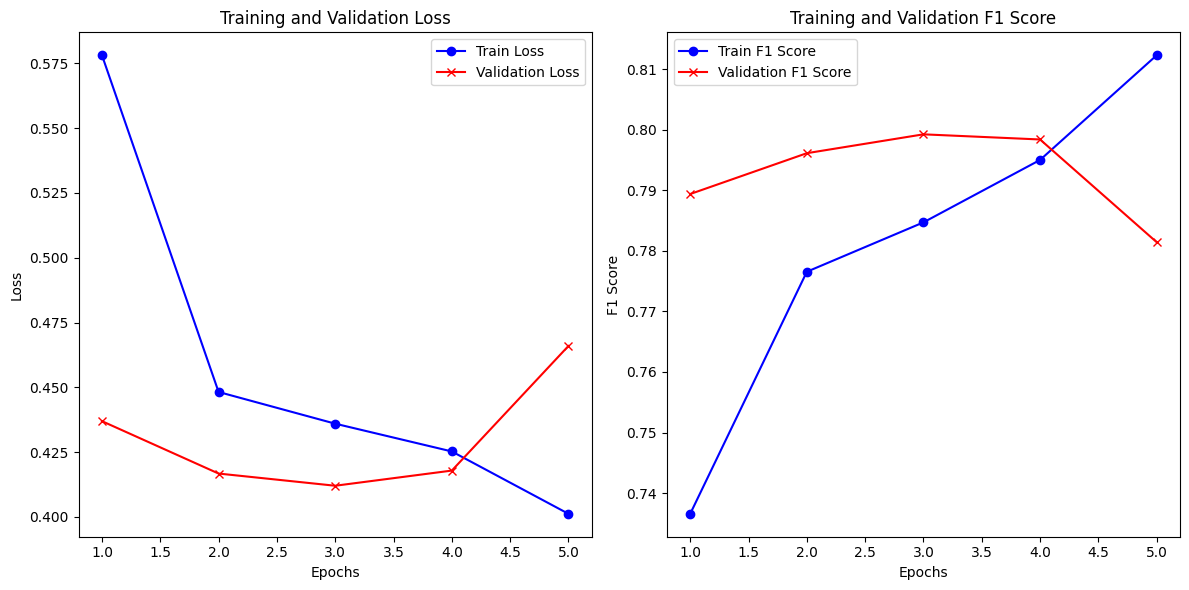

In [54]:
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

# 하드웨어 설정 (GPU 사용 가능 시 GPU로 설정)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# 모델 생성 및 이동
model = MyCNN().to(device)

# 손실 함수와 옵티마이저 정의
criterion = nn.CrossEntropyLoss()  # 다중 클래스 분류 문제에 적합한 손실 함수
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam 옵티마이저

# F1 점수 계산 함수
def calculate_f1_score(predictions, labels):
    return f1_score(labels.cpu(), predictions.cpu(), average='weighted')

# 훈련 함수
def train(model, train_loader, optimizer, criterion, device):
    model.train()  # 모델을 훈련 모드로 설정
    running_loss = 0.0
    all_preds = []
    all_labels = []

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)  # 데이터를 GPU로 이동

        # 옵티마이저 초기화
        optimizer.zero_grad()

        # 순전파
        outputs = model(images)
        loss = criterion(outputs, labels)

        # 역전파 및 가중치 업데이트
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # 예측값 저장
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted)
        all_labels.extend(labels)

    # F1 점수 계산
    f1 = calculate_f1_score(torch.tensor(all_preds), torch.tensor(all_labels))
    return running_loss / len(train_loader), f1

# 검증 함수
def validate(model, val_loader, criterion, device):
    model.eval()  # 모델을 평가 모드로 설정
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():  # 평가 시에는 역전파 계산 비활성화
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            # 예측값 계산
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            all_preds.extend(predicted)
            all_labels.extend(labels)

    accuracy = correct / total
    # F1 점수 계산
    f1 = calculate_f1_score(torch.tensor(all_preds), torch.tensor(all_labels))
    return running_loss / len(val_loader), accuracy, f1

# 훈련 및 검증
num_epochs = 5
best_val_loss = float('inf')

train_losses = []
val_losses = []
f1_train = []
f1_val = []

for epoch in range(num_epochs):
    train_loss, train_f1 = train(model, train_loader, optimizer, criterion, device)
    val_loss, val_accuracy, val_f1 = validate(model, val_loader, criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    f1_train.append(train_f1)
    f1_val.append(val_f1)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}, Train F1 Score: {train_f1:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}, Val F1 Score: {val_f1:.4f}")

    # 검증 손실이 개선되면 모델 저장
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_model.pth")
        print("모델 저장 완료: 검증 손실이 개선되었습니다.")

print("훈련 완료!")

# 훈련 및 검증 손실 그래프 그리기
plt.figure(figsize=(12, 6))

# 손실 그래프
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss', color='blue', marker='o')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss', color='red', marker='x')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# F1 점수 그래프
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), f1_train, label='Train F1 Score', color='blue', marker='o')
plt.plot(range(1, num_epochs+1), f1_val, label='Validation F1 Score', color='red', marker='x')
plt.title('Training and Validation F1 Score')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()

plt.tight_layout()
plt.show()
